In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

print_tensor = lambda n, x: print(n, type(x), x.shape, x.min(), x.max())

def plotOneImage(img, cmap = None, title = None):
    plt.figure()
    plt.imshow(img, cmap=plt.get_cmap(cmap))
    if title is not None:
        plt.xlabel(title)
    plt.show()
#     plt.colorbar(extend='both')


def plot2Image(img_2d, mask_2d, cmap='viridis',
               fig_title = None, save_dir= None):
    img_3d = [img_2d, mask_2d]
    fig = plt.figure(figsize=(8, 4))
    for i in range(2):
        fig.add_subplot(1, 2, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.grid(False)
        plt.imshow(img_3d[i], cmap=cmap)
    # plt.colorbar()
#     plt.colorbar(extend='both')
    if bool(save_dir):
        fig.savefig(os.path.join(save_dir, str(fig_title)))
        plt.close()
    else:
        if fig_title is not None:
            plt.xlabel(str(fig_title))
        plt.show()
    


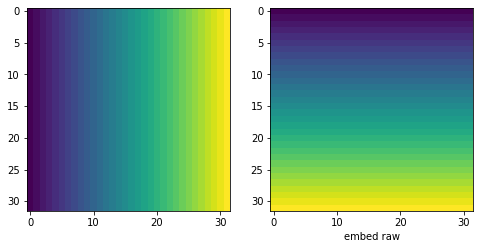

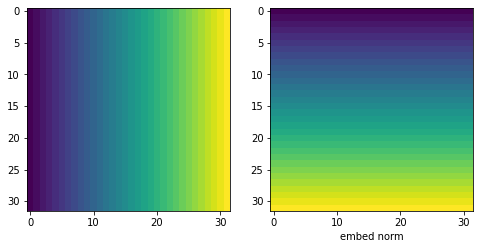

feature channels <class 'numpy.ndarray'> (256,) 1.0 9305.72040929699
pos x <class 'numpy.ndarray'> (1, 32, 32, 256) 2.1099868774693088e-05 6.283183343684791


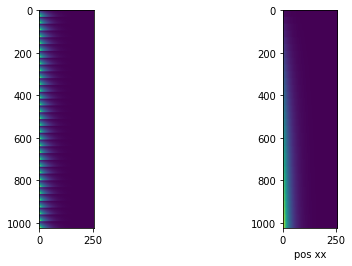

pos x sine <class 'numpy.ndarray'> (1, 32, 32, 256) -0.999999999999518 0.9999999999998795


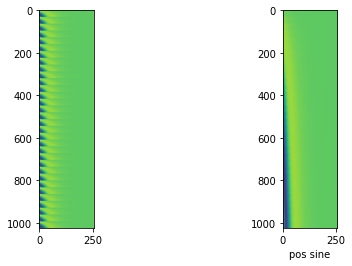

pos final <class 'numpy.ndarray'> (1, 32, 32, 512) -0.999999999999518 0.9999999999998795


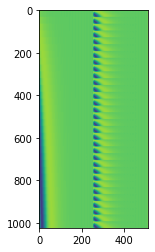

In [25]:
img_shape = (1, 32, 32)
scale = 2 * np.pi
eps = 1e-5
offset = 0
num_feats = 256 # 模型特征长度的一半，每个轴一半，并起来后可以实现相加。
temperature = 10000
normalize = True
mask = np.zeros(img_shape, dtype = float)


not_mask = 1 - mask  # logical_not
y_embed = not_mask.cumsum(1)
x_embed = not_mask.cumsum(2)
# print_tensor(' x embed', x_embed)
plot2Image(x_embed[0], y_embed[0], fig_title='embed raw')

if normalize:
    y_embed = (y_embed + offset) / (y_embed[:, -1:, :] + eps) * scale
    x_embed = (x_embed + offset) / (x_embed[:, :, -1:] + eps) * scale
# print_tensor('x embed norm', x_embed)
plot2Image(x_embed[0], y_embed[0], fig_title='embed norm')
    
dim_t = np.arange(num_feats, dtype=float)
dim_t = temperature**(2 * (dim_t // 2) / num_feats)
print_tensor('feature channels', dim_t)

pos_x = x_embed[:, :, :, None] / dim_t
pos_y = y_embed[:, :, :, None] / dim_t
print_tensor('pos x', pos_x)
plot2Image(pos_x[0].reshape(-1, num_feats), 
            pos_y[0].reshape(-1, num_feats),
            fig_title='pos xx')

# use `view` instead of `flatten` for dynamically exporting to ONNX
B, H, W = mask.shape

pos_x = np.stack([np.sin(pos_x[:, :, :, 0::2]), np.cos(pos_x[:, :, :, 1::2])], axis=4).reshape(B, H, W, -1)
pos_y = np.stack([np.sin(pos_y[:, :, :, 0::2]), np.cos(pos_y[:, :, :, 1::2])], axis=4).reshape(B, H, W, -1)
print_tensor('pos x sine', pos_x)
plot2Image(pos_x[0].reshape(-1, num_feats), 
            pos_y[0].reshape(-1, num_feats),
            fig_title='pos sine')


pos = np.concatenate((pos_y, pos_x), axis=3) #.transpose(0, 3, 1, 2)
print_tensor('pos final', pos)
plotOneImage(pos[0].reshape(-1, num_feats * 2))